In [2]:
# This notebook is for creating random monotonic models of Uranus.
# The only constraints on the model are the that innermost shell has a temperature less than 50K
# and that the temperature/density/composition/pressure are monotonically decreasing as the radius increases.

In [3]:
import random
import time
import numpy           as np
from matplotlib        import pyplot as plt
from matplotlib.pyplot import figure, legend

import lib.constants   as constants
import lib.profile     as profile
import lib.temperature as temperature
import lib.mc_interior as mc_interior
from joblib import Parallel, delayed
EPS = 1

In [4]:
# Set for Uranus
mass = constants.URANUS.mass
moment_ratio = constants.URANUS.moment_ratio
radius = constants.URANUS.radius
num_shells = 100
MIN_OUTER_DENSITY = 0.00

In [17]:
SMOOTH = 201
HE_ENV_CATALOG = True
ADD_CH4_TO_CATALOG = True
ADD_CO_TO_CATALOG = False
OUTER_SHELL_RATIO = 1
MIN_TEMP = 70
MAX_TEMP = 50000

def default_catalog():
    if HE_ENV_CATALOG:
        if ADD_CH4_TO_CATALOG and ADD_CO_TO_CATALOG:
            return temperature.iron_sio2_co_water_ch4_eos_he_catalog()
        elif ADD_CH4_TO_CATALOG:
            return temperature.iron_sio2_water_ch4_eos_he_catalog()
        elif ADD_CO_TO_CATALOG:
            return temperature.iron_sio2_co_water_eos_he_catalog()
        else:
            return temperature.iron_sio2_water_eos_he_catalog()
    else:
        if ADD_CH4_TO_CATALOG and ADD_CO_TO_CATALOG:
            return temperature.iron_sio2_co_water_ch4_eos_env_catalog()
        elif ADD_CH4_TO_CATALOG:
            return temperature.iron_sio2_water_ch4_eos_env_catalog()
        elif ADD_CO_TO_CATALOG:
            return temperature.iron_sio2_co_water_eos_env_catalog()
        else:
            return temperature.iron_sio2_water_eos_env_catalog()

catalog = default_catalog()

In [6]:
def get_fixed_temp_model(*args, **kwargs):
    seed, model, inner_temp, count = profile.get_fixed_temp_model(*args, **kwargs)
    if model is not None:
        if model._densities[-1] <= 0.001:
            model = inner_temp = cout = None
    return seed, model, inner_temp, count
            

In [7]:
def print_model(seed=None, catalog=catalog, num_shells=100, outer_two_shell_ratio=OUTER_SHELL_RATIO, min_temp=MIN_TEMP, max_temp=MAX_TEMP, smooth=SMOOTH, full_model=False):
    # First do the inverse
    seed, i_m, inner_temp, i_count = get_fixed_temp_model(mass, moment_ratio, radius, num_shells=num_shells,
                                                            outer_two_shell_ratio=outer_two_shell_ratio,
                                                            max_temp=min_temp,
                                                            seed=seed,
                                                            temperature_catalog=catalog,
                                                            full_model=True,
                                                            smooth=smooth,
                                                            min_density = MIN_OUTER_DENSITY,
                                                            inverse=True)
    retval = [seed]
    if ADD_CH4_TO_CATALOG:
        filename=str(seed)+"Tc"+str(max_temp)+"CH4.csv"
    elif ADD_CO_TO_CATALOG:
        filename=str(seed)+"Tc"+str(max_temp)+"CO.csv"
    else:
        filename=str(seed)+"Tc"+str(max_temp)+".csv"

    if i_m is None:
        inner_temp = max_temp
        retval.append((None, None, None))
   
    # Otherwise, need to generate the forward model.
    else:
        retval.append((i_m.get_mix_ratios(), inner_temp, i_count))        

        fp = open(filename, "w")
           
        fp.write("Inwards model\n*************\nComposition:\n");
        fp.write(",".join([str(x) for x in i_m.get_composition()])+'\n')
        fp.write("Pressure:\n");
        fp.write(",".join([str(x) for x in i_m.get_pressure()])+'\n')
        fp.write("Temperature:\n");
        fp.write(",".join([str(x) for x in i_m.get_temp()])+'\n')
        fp.write("Densities:\n");
        fp.write(",".join([str(x) for x in i_m.get_densities()])+'\n')
        fp.write("Radii:\n");
        fp.write(",".join([str(x) for x in i_m.get_radii()])+'\n\n')        
        fp.close()
       
    temp = max_temp
    seed, f_m, inner_temp, f_count = get_fixed_temp_model(mass, moment_ratio, radius, num_shells=num_shells,
                                                          outer_two_shell_ratio=outer_two_shell_ratio,
                                                          max_temp=max(temp, max_temp, inner_temp+EPS),
                                                          seed=seed,
                                                          temperature_catalog=catalog,
                                                          full_model=True,
                                                          smooth=smooth,
                                                          min_density = MIN_OUTER_DENSITY,
                                                          inverse=False)
    if f_m is None:
        retval.append((None, None, None))
    else:
        retval.append((f_m.get_mix_ratios(), inner_temp, f_count))
        fp = open(filename, "a")
           
        fp.write("Outwards model\n*************\nComposition:\n");
        fp.write(",".join([str(x) for x in f_m.get_composition()])+'\n')
        fp.write("Pressure:\n");
        fp.write(",".join([str(x) for x in f_m.get_pressure()])+'\n')
        fp.write("Temperature:\n");
        fp.write(",".join([str(x) for x in f_m.get_temp()])+'\n')
        fp.write("Densities:\n");
        fp.write(",".join([str(x) for x in f_m.get_densities()])+'\n')
        fp.write("Radii:\n");
        fp.write(",".join([str(x) for x in f_m.get_radii()])+'\n\n')
        fp.close()
       
    if i_m is None or f_m is None:
        retval.append((None, None, None))
        return retval
   
    # Now do the both_ends model
    cf = f_m.get_composition()
    ci = i_m.get_composition()
    cc = [x if abs(x) > abs(y) else y for (x,y) in zip(cf,ci)]
    mix = []
    for comp in cc:
        mix.append(catalog.composition_to_mix(comp))
                     
    both =  mc_interior.MCInterior(f_m.get_radii(), f_m.get_densities(),mix, catalog)
    retval.append((both.get_mix_ratios(), both.get_inner_temp(), max(f_count, i_count)))
           
    fp = open(filename, "a")

    fp.write("Bidirectional model\n*************\nComposition:\n");
    fp.write(",".join([str(x) for x in both.get_composition()])+'\n')
    fp.write("Pressure:\n");
    fp.write(",".join([str(x) for x in both.get_pressure()])+'\n')
    fp.write("Temperature:\n");
    fp.write(",".join([str(x) for x in both.get_temp()])+'\n')
    fp.write("Densities:\n");
    fp.write(",".join([str(x) for x in both.get_densities()])+'\n')
    fp.write("Radii:\n");
    fp.write(",".join([str(x) for x in both.get_radii()])+'\n')

    fp.close()

In [8]:
# Create a bunch of random models.

def best_model(seed=None, catalog=catalog, min_temp=MIN_TEMP, max_temp=MAX_TEMP, smooth=SMOOTH, 
               full_model=False, debug=False, num_shells = 100, outer_two_shell_ratio=OUTER_SHELL_RATIO):
    # First do the inverse
 

    seed, i_m, inner_temp, i_count = get_fixed_temp_model(mass, moment_ratio, radius, num_shells=num_shells, 
                                                          outer_two_shell_ratio=outer_two_shell_ratio,
                                                          max_temp=min_temp,
                                                          seed=seed,
                                                          temperature_catalog=catalog,
                                                          full_model=True,
                                                          smooth=smooth,
                                                          min_density = MIN_OUTER_DENSITY,
                                                          inverse=True)
    retval = [seed]
    if i_m is None:
        inner_temp = max_temp
        retval.append((None, None, None))
    
    # Otherwise, need to generate the forward model.
    else:
        retval.append((i_m.get_mix_ratios(), inner_temp, i_count))

    seed, f_m, inner_temp, f_count = get_fixed_temp_model(mass, moment_ratio, radius, num_shells=num_shells, 
                                                          outer_two_shell_ratio=outer_two_shell_ratio,
                                                          max_temp=max(max_temp, inner_temp+EPS),
                                                          seed=seed,
                                                          temperature_catalog=catalog,
                                                          full_model=True,
                                                          smooth=smooth,
                                                          inverse=False,
                                                          min_density = MIN_OUTER_DENSITY,
                                                          debug=debug)
    if f_m is None:
        retval.append((None, None, None))
    else:
        retval.append((f_m.get_mix_ratios(), inner_temp, f_count))
        
    if i_m is None or f_m is None:
        retval.append((None, None, None))
        retval.append(None)
        retval.append(None)
        to_show = i_m
       
    else:
    # Now do the both_ends model
        cf = f_m.get_composition()
        ci = i_m.get_composition()

        cc = [x if abs(x) > abs(y) else y for (x,y) in zip(cf,ci)]
        mix = []
        for comp in cc:
            mix.append(catalog.composition_to_mix(comp))

        both =  mc_interior.MCInterior(i_m.get_radii(), i_m.get_densities(),mix, catalog, pressure=None, fixed_density=True) 
        retval.append((both.get_mix_ratios(), both.get_inner_temp(), max(f_count, i_count)))
        retval.append(both._densities[0])
        retval.append(both.get_composition()[-1])
        to_show = both
    
    if full_model:
        # Plot density
        to_show.plot_densities()
        figure()

        # Plot pressure
        to_show.plot_pressure()
        figure()

        # Plot temperature
        to_show.plot_temp()
        #f_m.plot_temp()
        figure()

        # Plot composition
        #both.plot_mix()
        to_show.plot_mix()
        figure()

        if f_m is not None:
            f_m.plot_composition("forward composition")
        i_m.plot_composition("inverse composition")
        to_show.plot_composition("both composition")
        figure()
        # plot temp profiles
        m_profile = profile.TemperatureProfile(catalog, to_show)
        m_profile.plot_temperature_profile()
        #figure()
        #m_profile.plot_water_env_temperature_profile()
        #figure()
        #m_profile.plot_rock_water_temperature_profile()
        retval.append(to_show)

    return retval
    
def wrapped_best_model(*args, **kwargs):
    try:
        return best_model(*args, **kwargs)
    except:
        if len(args) > 0:
            return args[0]
        elif len(kwargs) > 0:
            return kwargs[0]
        else:
            return None
    
def save_models(filename, model_list):
    fp = open(filename, "w")
    if ADD_CH4_TO_CATALOG:
        fp.write("seed, inv_env, inv_ch4, inv_water, inv_sio2, inv_iron, inv_temp, inv_count,"+ \
                 " fwd_env, fwd_ch4, fwd_water, fwd_sio2, fwd_iron, fwd_temp, fwd_count, bth_env,"+ \
                 " bth_ch4, bth_water, bth_sio2, bth_iron, bth_temp, bth_count\n")
    elif ADD_CO_TO_CATALOG:
        fp.write("seed, inv_env, inv_water, inv_co, inv_sio2, inv_iron, inv_temp, inv_count, "+ \
                 "fwd_env, fwd_water, fwd_co, fwd_sio2, fwd_iron, fwd_temp, fwd_count, bth_env, "+ \
                 "bth_water, bth_co, bth_sio2, bth_iron, bth_temp, bth_count\n")
    else:
        fp.write("seed, inv_env, inv_water, inv_sio2, inv_iron, inv_temp, inv_count, fwd_env, "+ \
                 "fwd_water, fwd_sio2, fwd_iron, fwd_temp, fwd_count, bth_env, bth_water, "+ \
                 "bth_sio2, bth_iron, bth_temp, bth_count\n")    
    for model in model_list:
        if len(model) == 1:
            fp.write(model[0]+'\n')
            continue
        seed, inv, fwd, bth, rho, comp = model
        def to_list(x):
            if x[0] is None:
                return [None, None, None, x[1], x[2]]
            else:
                return x[0] + [x[1], x[2]]
        line = [seed]+to_list(inv)+to_list(fwd)+to_list(bth)+[rho,comp]
        #print(line)
        fp.write(",".join([str(x) for x in line])+'\n')
    fp.close()
    
def create_composition_from_temp_model(filename, catalog):
    """
    This function loads a model from file and computes composition
    File must be in csv format, with the following rows in order:
    
    - pressure (psi)
    - temperature (K)
    - density (g/cc)
    - radius (cm)
    
    There can be other rows in the file, code will only take first 4 rows of length > 10.
    Note:   Also need catalog, as this is needed to interpret temperature.
    """
    fp = open(filename, "r")
    rows =  [i.strip('\n').split(',') for i in open(filename,"r")]

    # First four "long" rows
    long_rows = [x for x in filter(lambda x: len(x)> 10, rows)]
    pressure, temp, rho, r = long_rows[:4]
    pressure = [float(x) for x in pressure]
    rho = [float(x) for x in rho]
    r = [float(x) for x in r]
    temp = [float(x) for x in temp]
    
    # Compute composition
    comp = [catalog.get_composition(t,d,p) for (t,d,p) in zip(temp, rho, pressure)]
    mix = [catalog.composition_to_mix(x) for x in comp]

    model = mc_interior.MCInterior(r, rho, mix, catalog)
    model._pressure = pressure
    return model


In [9]:
good_models = []
bad_models = []
error_models = []
seeds = np.loadtxt("data/raw_files/seeds.txt").tolist()
N = len(seeds)
N=8
t0 = time.monotonic()

retval = Parallel(n_jobs=146)(delayed(wrapped_best_model)(seeds[i],max_temp=MAX_TEMP) for i in range(N))
for i in range(N):
    try:
 
        seed, inv, fwd, bth, rho, comp = retval[i]
        if inv[0] is None and fwd[0] is None and bth[0] is None:
            bad_models.append((seed, inv, fwd, bth, rho, comp))
        else:
            good_models.append((seed, inv, fwd, bth, rho, comp))
    except:
        error_models.append(retval[i])
       
print("errors in %s models"%len(error_models))
t = time.monotonic()

errors in 0 models


In [11]:
save_models("4mat_Tc40000_100000_good_models_of_200_shells_smoothing_401_new.csv", good_models)
save_models("4mat_Tc40000_100000_error_models_of_200_shells_smoothing_401_new.csv", error_models)
save_models("4mat_Tc40000_100000_bad_models_of_200_shells_smoothing_401_new.csv", bad_models)

In [12]:
"""
model1 = create_composition_from_temp_model("OldTemperature.csv", catalog)
model2 = create_composition_from_temp_model("NewTemperature.csv", catalog)

print(model1.get_mix_ratios())
print(model2.get_mix_ratios())
figure()
model1.plot_densities()
model2.plot_densities()
figure()
model1.plot_pressure()
model2.plot_pressure()
figure()
model1.plot_temp()
model2.plot_temp()
figure()
model1.plot_mix()
model2.plot_mix()
figure()
model1.plot_composition()
model2.plot_composition()
"""

'\nmodel1 = create_composition_from_temp_model("OldTemperature.csv", catalog)\nmodel2 = create_composition_from_temp_model("NewTemperature.csv", catalog)\n\nprint(model1.get_mix_ratios())\nprint(model2.get_mix_ratios())\nfigure()\nmodel1.plot_densities()\nmodel2.plot_densities()\nfigure()\nmodel1.plot_pressure()\nmodel2.plot_pressure()\nfigure()\nmodel1.plot_temp()\nmodel2.plot_temp()\nfigure()\nmodel1.plot_mix()\nmodel2.plot_mix()\nfigure()\nmodel1.plot_composition()\nmodel2.plot_composition()\n'

[718.513689012,
 ([0.2, 0.57, 0.24, 0.0], 53328.150726131025, 0),
 ([0.2, 0.57, 0.24, 0.0], 53329.033240984834, 0),
 ([0.2, 0.57, 0.24, 0.0], 53329.033240984834, 0),
 6.519153673439238,
 -1.0,

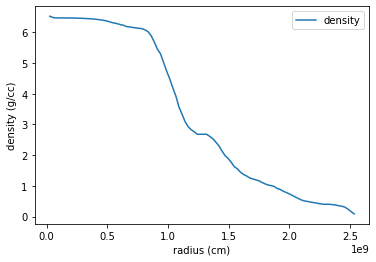

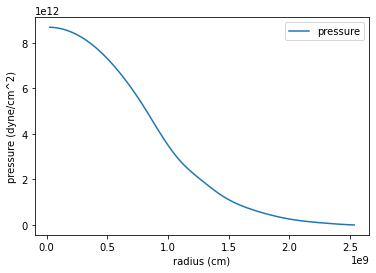

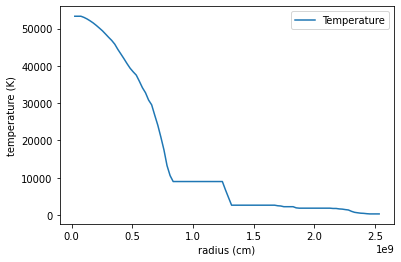

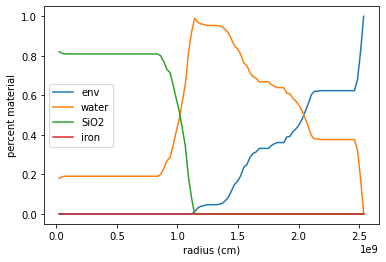

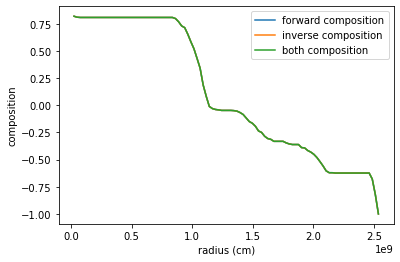

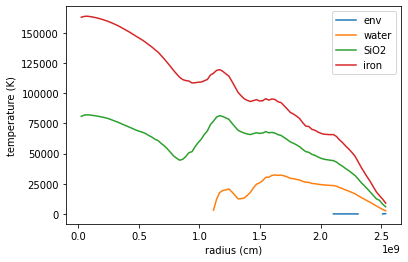

In [19]:
model = best_model( 718.513689012, temperature.iron_sio2_water_eos_env_catalog(), max_temp=40000, min_temp=0, full_model=True, smooth=201, outer_two_shell_ratio=1)
model

[713,
 ([0.07, 0.53, 0.4, 0.0], 61332.47370844438, 0),
 ([0.07, 0.53, 0.4, 0.0], 61333.52447808667, 0),
 ([0.07, 0.53, 0.4, 0.0], 61333.52447808667, 0),
 7.57607575957234,
 -0.24854660034179688,

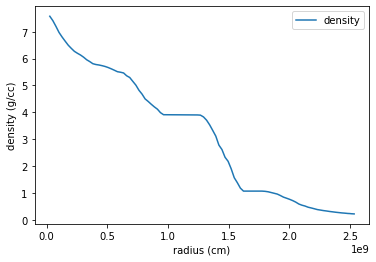

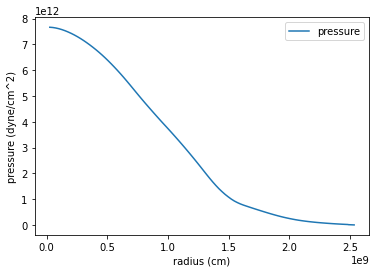

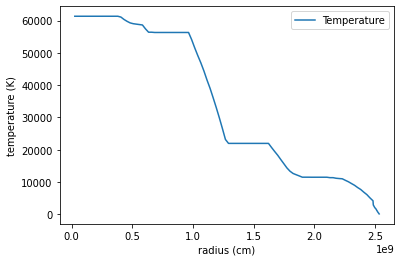

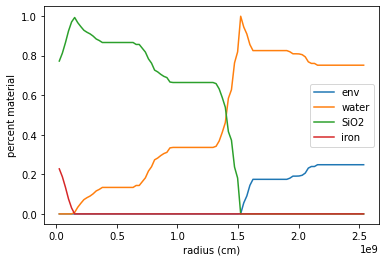

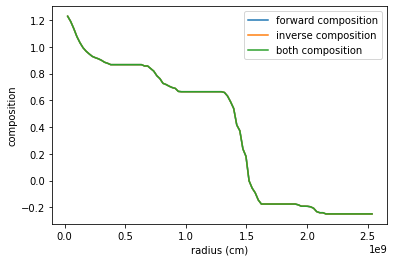

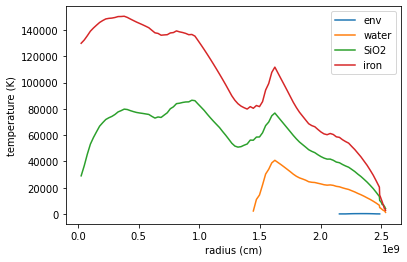

In [34]:
model = wrapped_best_model( 713, temperature.iron_sio2_water_eos_env_catalog(), max_temp=40000, min_temp=0, full_model=True, smooth=201, outer_two_shell_ratio=10)
model

[718.513689012,
 ([0.25, 0.18, 0.33, 0.24, 0.0], 54097.90480627033, 14),
 (None, None, None),
 (None, None, None),
 None,
 None,

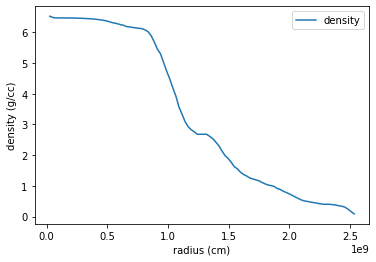

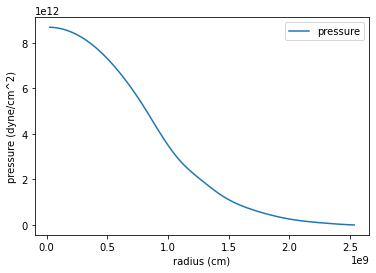

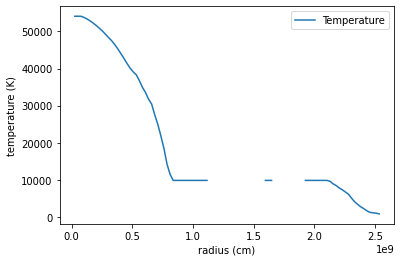

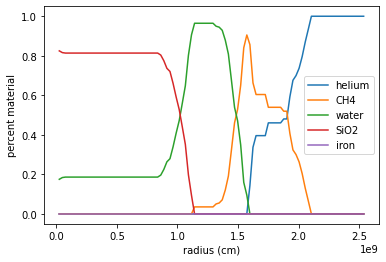

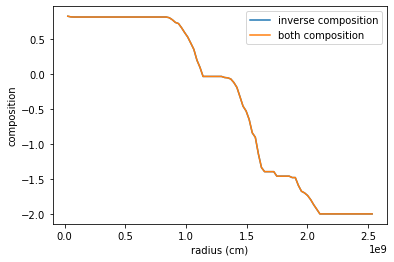

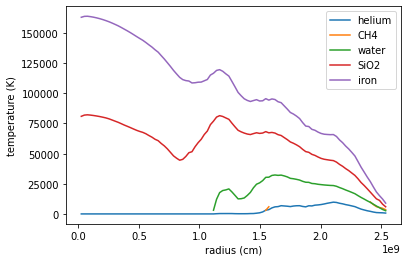

In [14]:
model = best_model( 718.513689012, temperature.iron_sio2_water_ch4_eos_he_catalog(), max_temp=40000, min_temp=0, full_model=True, smooth=201)
model

[773.332127703,
 ([0.16, 0.0, 0.2, 0.63, 0.0], 94534.2119074806, 0),
 ([0.0, 0.0, 0.37, 0.63, 0.0], 94535.83262561676, 3),
 ([0.16, 0.0, 0.2, 0.63, 0.0], 94535.83262561676, 3),
 9.368750894239309,
 -2.0,

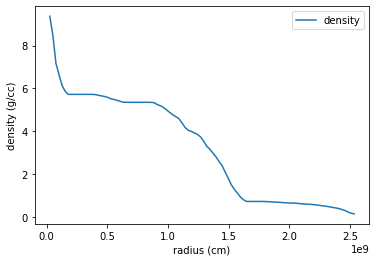

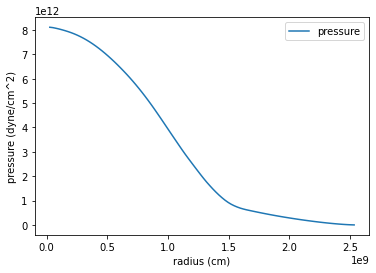

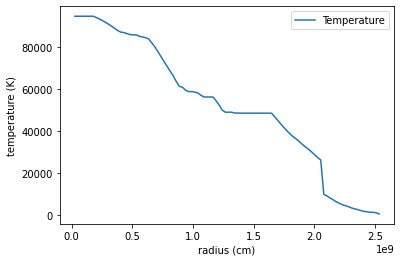

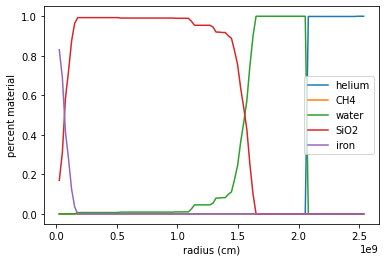

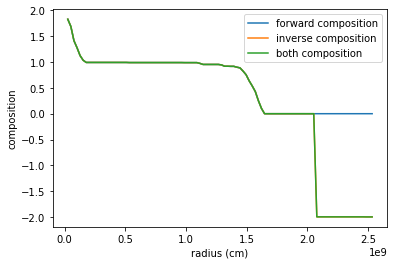

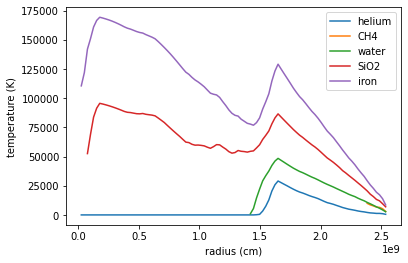

In [15]:
model = best_model( 773.332127703, catalog, max_temp=40000, min_temp=0, full_model=True, smooth=201)
model

In [16]:
# Uncomment to create seeds

#N_models=100000
#seeds = [round(1000.0*random.random(),9) for x in range(N_models)]
#str_out = 'seeds.txt'
#np.savetxt(str_out, seeds, delimiter=',',fmt='%1.9f')